In [1]:
# Import Libs

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron, LinearRegression
from sklearn.ensemble import RandomForestClassifier


# Load the data
filename = './AI_Project_Data/cleaned_data.csv'
employee_data = pd.read_csv(filename)

# Displaying data.head() to see the first 5 rows of the data
employee_data.head()

,Age,Attrition,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,...,MaritalStatus_Married,MaritalStatus_Single,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,mean_worked_hours,total_worked_hours,worked_days
0,51,False,6,2,1,1,131160,1,11,0,...,1,0,3,4,2,3,3,7.373651,1710.686944,232
1,31,True,10,1,2,1,41890,0,23,1,...,0,1,3,2,4,2,4,7.718969,1821.676667,236
2,32,False,17,4,3,4,193280,1,15,3,...,1,0,2,2,1,3,3,7.013240,1697.204167,242
3,38,False,2,5,4,3,83210,3,11,3,...,1,0,4,4,3,2,3,7.193678,1690.514444,235
4,32,False,10,1,5,1,23420,4,12,2,...,0,1,4,1,3,3,3,8.006175,1961.512778,245


# Predict Attrition values

In [2]:
employee_df = employee_data.copy()

y = employee_df["Attrition"]
X = employee_df.drop(columns=["Attrition"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # TODO : shuffle ? cross validation


models = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "RandomForest": RandomForestClassifier(random_state=42), 
    "Perceptron": Perceptron(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
}

Training LogisticRegression...
Training SVC...


c:\Users\Paul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training KNeighborsClassifier...
Training NaiveBayes...
Training RandomForest...
Training Perceptron...
Training DecisionTreeClassifier...


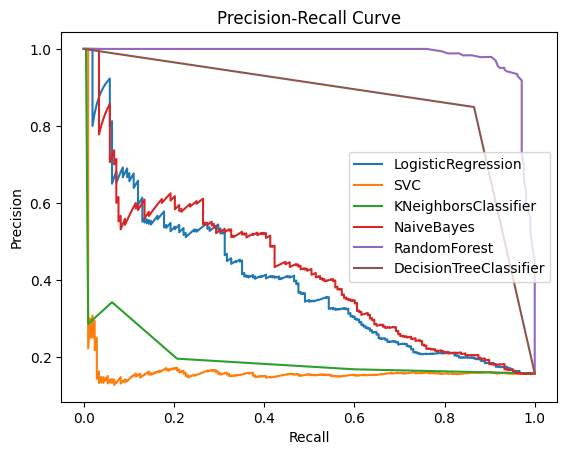

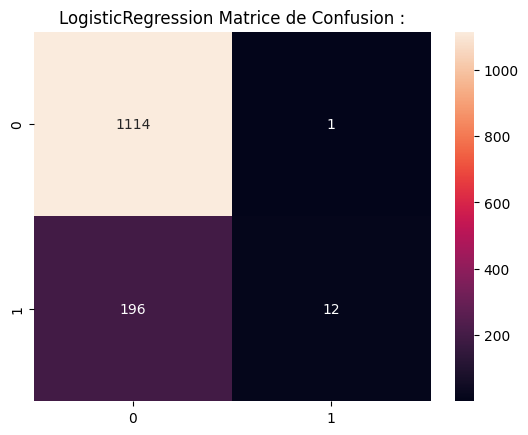

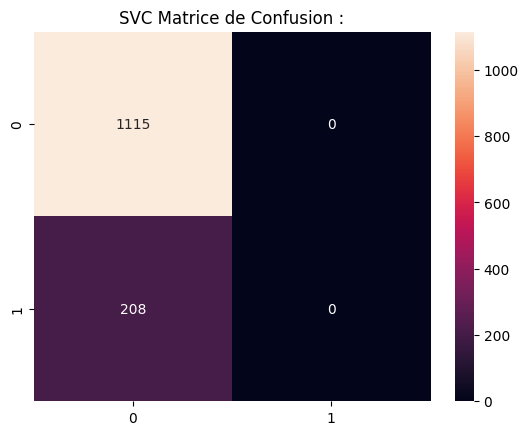

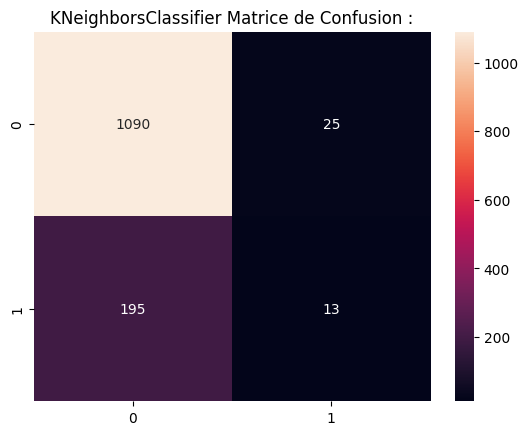

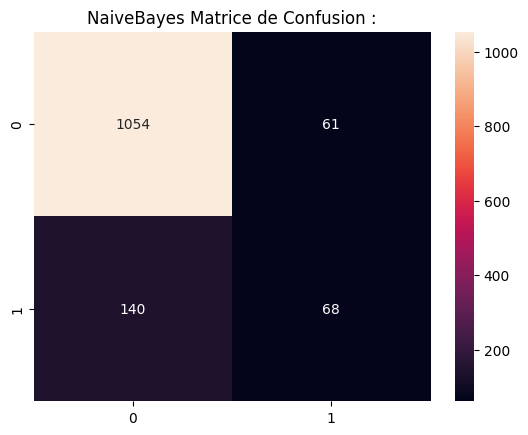

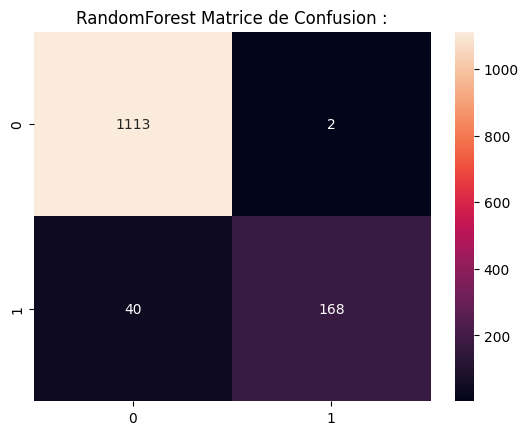

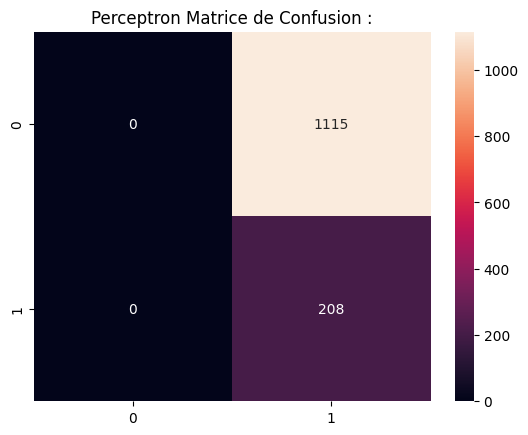

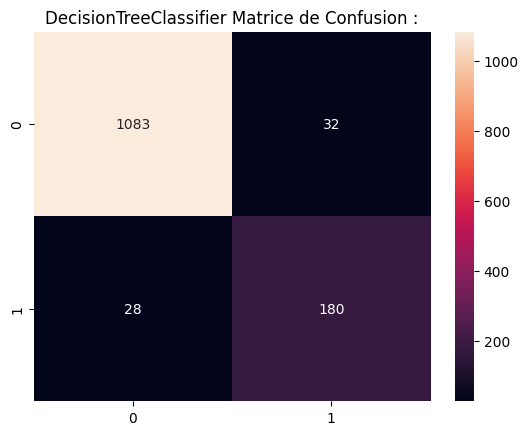

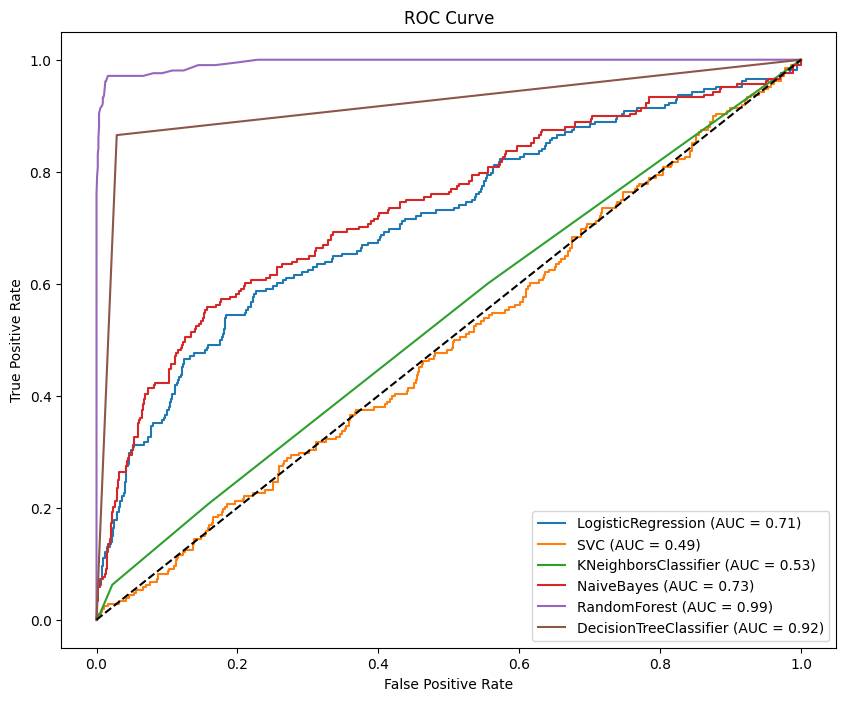

                    Model  Precision    Recall  F1 Score  Accuracy
0      LogisticRegression   0.923077  0.057692  0.108597  0.851096
1                     SVC   0.000000  0.000000  0.000000  0.842782
2    KNeighborsClassifier   0.342105  0.062500  0.105691  0.833711
3              NaiveBayes   0.527132  0.326923  0.403561  0.848073
4            RandomForest   0.988235  0.807692  0.888889  0.968254
5              Perceptron   0.157218  1.000000  0.271718  0.157218
6  DecisionTreeClassifier   0.849057  0.865385  0.857143  0.954649
__________________________________________________
Sorted Dataframe
__________________________________________________
                    Model  Precision    Recall  F1 Score  Accuracy
4            RandomForest   0.988235  0.807692  0.888889  0.968254
6  DecisionTreeClassifier   0.849057  0.865385  0.857143  0.954649
3              NaiveBayes   0.527132  0.326923  0.403561  0.848073
5              Perceptron   0.157218  1.000000  0.271718  0.157218
0      Log

c:\Users\Paul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
predictions = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    predictions[model_name] = model.predict(X_test)    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=f"{model_name}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"{name} Matrice de Confusion :")
    plt.show()


plt.figure(figsize=(10, 8)) 
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

scores = []
for name, y_pred in predictions.items():
    scores.append({
        'Model': name,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred),
    })

scores_df = pd.DataFrame(scores)
print(scores_df)
print('_'*50)
print('Sorted Dataframe')
print('_'*50)
scores_df = scores_df.sort_values(['F1 Score', 'Precision', 'Accuracy', 'Recall'], ascending=False) # TODO : change order
print(scores_df)

## Optimize model

full params grids : 

svc_params_grid = {
    # general parameters
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'class_weight': [None, 'balanced'],
    'decision_function_shape': ['ovo', 'ovr'],
    'random_state': [42],
    'shrinking': [True, False],
    'probability': [True],
    'cache_size': [200, 500, 1000],
    'verbose': [False],
    
    # specific parameters for the 'rbf' and 'sigmoid' kernels
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1],
    
    # Specific polyinomial kernel parameters
    'degree': [2, 3, 4, 5],
    'coef0': [0.0, 0.1, 0.5, 1.0],
    
    # tolerance and maximum number of iterations
    'tol': [1e-5, 1e-4, 1e-3],
    'max_iter': [-1, 1000, 2000, 5000]
}


rf_params_grid = {
    # Paramètres de la forêt
    'n_estimators': [100, 200, 300, 500],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    
    # Paramètres des arbres individuels
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 50, 100, 200],
    
    # Paramètres de randomisation
    'random_state': [42],
    
    # Paramètres pour données déséquilibrées
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    
    # Paramètres de parallélisation
    'n_jobs': [-1],
    
    # Paramètres de critère de split
    'criterion': ['gini', 'entropy', 'log_loss'],
    
    # Paramètres de régularisation
    'max_samples': [0.5, 0.7, 0.9, None],
    'min_impurity_decrease': [0.0, 0.01, 0.1]
}


In [4]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


# Définition d'une grille simplifiée de paramètres
rf_params_grid = {
    # Paramètres essentiels
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    
    # Paramètres de base
    'random_state': [42],
    'n_jobs': [-1],
    'class_weight': [None, 'balanced']
}
# Configuration du GridSearchCV avec des options avancées
RandomForest_model = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_params_grid,
    cv=5,  # Validation croisée à 5 plis
    n_jobs=-1,  # Utilise tous les cœurs disponibles
    scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'],
    refit='accuracy',  # Réentraîne sur la meilleure métrique accuracy
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

# model fitting
RandomForest_model.fit(X_train, y_train)

# getting best parameters
best_rf_model = RandomForest_model.best_estimator_

# displaying results
print("\nMeilleurs paramètres trouvés :")
print(f"\nRandomForest {RandomForest_model.best_params_}")
print("\nMeilleur score de validation croisée:")
print(f"\nRandomForest {RandomForest_model.best_score_}")


# displaying scores for metrics
rf_results = pd.DataFrame(RandomForest_model.cv_results_)
print("\nRésultats détaillés pour la meilleure configuration:")
metrics = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
for metric in metrics:
    mean_score = rf_results[f'mean_test_{metric}'].iloc[rf_results['rank_test_accuracy'].argmin()]
    std_score = rf_results[f'std_test_{metric}'].iloc[rf_results['rank_test_accuracy'].argmin()]
    print(f"RandomForest - {metric}: {mean_score:.3f} (+/- {std_score*2:.3f})")
    
    

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Meilleurs paramètres trouvés :

RandomForest {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}

Meilleur score de validation croisée:

RandomForest 0.9621023534903724

Résultats détaillés pour la meilleure configuration:
RandomForest - accuracy: 0.962 (+/- 0.016)
RandomForest - f1: 0.869 (+/- 0.058)
RandomForest - precision: 0.992 (+/- 0.013)
RandomForest - recall: 0.773 (+/- 0.090)
RandomForest - roc_auc: 0.980 (+/- 0.014)
